<a href="https://colab.research.google.com/github/Shnku/pythoning_stuff/blob/proj/NN/build_cnn/expr2_resnet18_two_output.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initial setup

## Mount google-drive & Load dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#shared path to drive
SHARED_PATH="/content/drive/MyDrive/Classroom/ChandernagoreCollegeSemVI-Addon 2025 Sem VI Computer Science Honours/ChandernagoreCollegeSemVI-Addon 2025 Sem VI Computer Science Honours"

#direct path to drive
DIRECT_PATH="/content/drive/MyDrive/Classroom/ChandernagoreCollegeSemVI-Addon 2025 Sem VI Computer Science Honours"

Mounted at /content/drive


In [ ]:
import os

# Determine the data path based on the existence of shared or direct paths
root_path = SHARED_PATH if os.path.exists(SHARED_PATH) else DIRECT_PATH if os.path.exists(DIRECT_PATH) else None

DATA_PATH = ''
# Print the chosen path or an error message
if root_path:
    print(f"Using path: {root_path}")
    DATA_PATH = root_path + "/Proj1_CGC_Building_with_sides_classify"
    for filename in os.listdir(DATA_PATH):
        print(filename)
else:
    print("Neither shared nor direct path exists. Please check the paths.")


Using path: /content/drive/MyDrive/Classroom/ChandernagoreCollegeSemVI-Addon 2025 Sem VI Computer Science Honours
make_train-test-split_from_all_img_data.ipynb
ResNet18_with_56_accy.pth
expr1_resnet18.ipynb
validate_images
training_images
ALL_IMG_DATA


## Importing pytorch and setup CPU or GPU

In [ ]:
import torch
import random
import torchvision
import numpy as np
import matplotlib.pyplot as plt

# Define device (CPU or GPU)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cpu


#### Setup random state

In [ ]:
# define the random seed
SEED = 2025

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(SEED)

# Data Importing and Modification and Loading

In [ ]:
path_train_data= DATA_PATH + "/training_images"
path_test_data= DATA_PATH + "/validate_images"

## Define Data Transformations (Data Augmentation)

Data transformations are applied to the training images to artificially increase the size and variability of the dataset.
- This helps the model become more robust and generalize better to unseen images.
- By introducing variations like *rotations, flips, color changes, and affine transformations,* **we prevent the model from overfitting to the specific characteristics of the original training data.**
- This is particularly important for smaller datasets.

**For the test set,** only basic transformations like *resizing and normalization* are applied to ***prepare the images for the model without altering their content.***

In [ ]:
import torchvision.transforms as transforms

mean=[0.485, 0.456, 0.406]
standev=[0.229, 0.224, 0.225]
px=256

train_transform = transforms.Compose([
    transforms.Resize((px, px)),
    transforms.RandomCrop((224, 224)),
    transforms.RandomRotation(10),
    # transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(),
    transforms.RandomAffine(degrees=0),
    transforms.ToTensor(),
    transforms.Normalize(mean=(mean), std=(standev))
])

test_transform =  transforms.Compose([
    transforms.Resize((px, px)),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(mean), std=(standev))
])

print(train_transform)

Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
    RandomCrop(size=(224, 224), padding=None)
    RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
    RandomHorizontalFlip(p=0.5)
    ColorJitter(brightness=None, contrast=None, saturation=None, hue=None)
    RandomAffine(degrees=[0.0, 0.0])
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


## Load dataset with Torch

In [ ]:
from torchvision.datasets import ImageFolder

train_dataset = ImageFolder(root=path_train_data, transform=train_transform)
test_dataset = ImageFolder(root=path_test_data, transform=test_transform)

print(train_dataset)
print(test_dataset)

Dataset ImageFolder
    Number of datapoints: 295
    Root location: /content/drive/MyDrive/Classroom/ChandernagoreCollegeSemVI-Addon 2025 Sem VI Computer Science Honours/Proj1_CGC_Building_with_sides_classify/training_images
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
               RandomCrop(size=(224, 224), padding=None)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
               ColorJitter(brightness=None, contrast=None, saturation=None, hue=None)
               RandomAffine(degrees=[0.0, 0.0])
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Dataset ImageFolder
    Number of datapoints: 74
    Root location: /content/drive/MyDrive/Classroom/ChandernagoreCollegeSemVI-Addon 2025 Sem VI Computer Science Honours/Proj1_CGC_Buildin

In [ ]:
print(train_dataset.class_to_idx)
print(len(train_dataset.class_to_idx))

{'admin_front': 0, 'admin_left': 1, 'admin_right': 2, 'chemistry_front': 3, 'chemistry_left': 4, 'chemistry_right': 5, 'gurudeb_front': 6, 'gurudeb_left': 7, 'gurudeb_right': 8, 'heritage_front': 9, 'heritage_left': 10}
11


## Data loader

### Define ***Batch-Size (Hyper-parameter)***

The batch size is a hyperparameter that defines the **number of samples** that will be propagated through the network at once during training.

- **Larger batch sizes:**
  - can lead to faster training per epoch due to **better utilization of hardware**,
  - but they require more memory and might converge to sharper minima, *which may **not generalize as well**.*
- **Smaller batch sizes:**
  - introduce more noise in the gradient updates,
  - which can help the *model escape local minima* and potentially lead to **better generalization**,
  - but training can be **slower**.

In [ ]:
BATCH_SIZE = 16

### Create DataLoader instances

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Example of iterating through the DataLoader
for images, labels in train_loader:
    print(f"Batch of images shape: {images.shape}")
    print(f"Batch of labels shape: {labels.shape}")
    break
     # Just show one batch


Batch of images shape: torch.Size([16, 3, 224, 224])
Batch of labels shape: torch.Size([16])


### Visualization of transformation

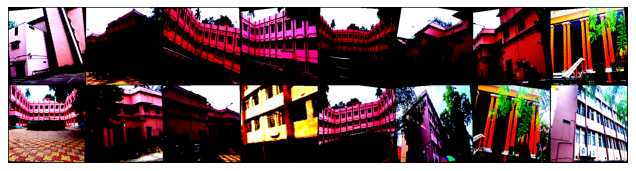

labels: tensor([ 2,  4,  8,  7,  6,  5,  4, 10,  6,  5,  4,  0,  6,  1, 10,  0])


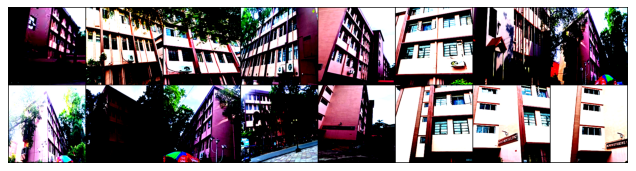

labels: tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2])


In [ ]:
def disp_img_grid(dataloader, mean, std):
    batch = next(iter(dataloader))
    img, lbl = batch

    grid = torchvision.utils.make_grid(img, nrow=8)
    plt.figure(figsize=(10, 10), dpi=80)

    # Ensure the pixel values are within the displayable range [0, 1] or [0, 255]
    # Clamping to [0, 1] is usually sufficient for imshow
    grid = torch.clamp(grid, 0, 1)

    plt.imshow(grid.permute(1, 2, 0).numpy()) # c0/h1/w2 -> h0/w1/c2
    plt.axis('off')
    plt.show()
    print(f'labels: {lbl}')

# Example usage with your existing DataLoaders:
disp_img_grid(train_loader, mean=mean, std=standev)
disp_img_grid(test_loader, mean=mean, std=standev)

# CNN Defining and Training part

## Use Readymade CNN Model(ResNet) and modify it

In [ ]:
# Load torch's ResNet18 model
import torchvision.models as models
import torch.nn as nn

# CNN_MODEL = models.resnet18(weights ='ResNet18_Weights.DEFAULT')  # pretrained = True/false
CNN_MODEL = models.resnet18(weights = None) # pretrained = False)
# CNN_MODEL = models.efficientnet_b4(weights = '') # pretrained = False)

### We have to modify the last layer

This code replaces the standard last layer of the ResNet with new layers (including an intermediate layer and dropout) to classify our specific building types instead of the original ImageNet categories.

In [ ]:
import torch.nn as nn

class TwoOutputs(nn.Module):
  """
  A class contains Linear and ReLU modules.
  The class provides two outputs.
  One output is the building classification.
  Other output is the facade/direction classification.

  """
  def __init__(self, in_feature, mid_feature, out_feature): # Define parameters here
    """

    Initialization function for two fully connected (FC) feed-forward networks.

    """
    super().__init__()

    # Assign parameters to instance attributes
    self.in_feature = in_feature
    self.mid_feature = mid_feature
    self.out_feature = out_feature

    # Building Classification
    self.linear11 = nn.Linear(in_features=self.in_feature, out_features=self.mid_feature)
    self.relu11 = nn.ReLU()
    self.dropout11 = nn.Dropout(p=0.2)
    self.linear12 = nn.Linear(in_features=self.mid_feature,
                              out_features=self.out_feature)
    self.softmax12 = nn.Softmax(dim=1)

    # Directation/Side/Facade Prediction (Left/Front/Right)
    self.linear21 = nn.Linear(in_features=self.in_feature, out_features=self.mid_feature)
    self.relu21 = nn.ReLU()
    self.dropout21 = nn.Dropout(p=0.2)
    # Correct the in_features for the second linear layer to match mid_feature
    self.linear22 = nn.Linear(in_features=self.mid_feature,
                              out_features=self.out_feature // 3) # Use self.out_feature
    self.softmax22 = nn.Softmax(dim=1)

  def forward(self, x):
    """
    Feed-forward function for two fully connected (FC) feed-forward networks.

    """
    output1 = self.linear11(x)
    output1 = self.relu11(output1)
    output1 = self.dropout11(output1)
    output1 = self.linear12(output1)
    output1 = self.softmax12(output1)

    output2 = self.linear21(x)
    output2 = self.relu21(output2)
    output2 = self.dropout21(output2)
    output2 = self.linear22(output2)
    output2 = self.softmax22(output2)

    return output1, output2

In [ ]:
# modifying the last layer
# ResNet models have a 'fc' layer as the last linear layer
last_layer_in = CNN_MODEL.fc.in_features
no_of_classes = len(train_dataset.class_to_idx)
new_mid_layer_out = 256

print(f"last layer output for model = {last_layer_in} -> {new_mid_layer_out} -> convert to {no_of_classes} output")

# CNN_MODEL.fc = nn.Linear(last_layer_in, no_of_classes)
CNN_MODEL.fc = TwoOutputs(last_layer_in,new_mid_layer_out,no_of_classes)

last layer output for model = 512 -> 256 -> convert to 11 output


### Model's Weights and biases Initialization

This section initializes the weights and biases of the neural network model.
It iterates through the model's layers and applies specific initialization methods
to the linear layers (fully connected layers).

 - **Kaiming Normal Initialization (`init.kaiming_normal_`):**
  - Used ***for weights.***
  - This method is particularly effective for layers that use the ReLU activation function,
  - Helping to prevent issues like **vanishing or exploding gradients** during training.
 - **Normal Initialization (`init.normal_`):**
   - Used ***for biases***. Biases are
   - initialized with small random values.
   - Proper initialization is important for training deep learning models efficiently and effectively.

In [ ]:
import torch.nn.init as init

# with torch.no_grad():
for module in CNN_MODEL.modules():
    if isinstance(module, nn.Linear):
        init.kaiming_normal_(
            module.weight, a=0, mode='fan_out', nonlinearity='relu',
        )
        if module.bias is not None:
            fan_in, fan_out = init._calculate_fan_in_and_fan_out(module.weight)
            bound = 1 / (fan_out)**0.5
            init.normal_(module.bias, -bound, bound)

### Send the model to GPU/CPU

In [ ]:
# Move model to device
CNN_MODEL = CNN_MODEL.to(DEVICE)
print(CNN_MODEL)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Define loss function
For *a **classification task** like this, **CrossEntropyLoss** is a common and effective choice.*
- It combines LogSoftmax and NLLLoss in one single class.
- The output of the model (logits) is compared to the true labels, and the loss
- represents the error between the predicted probabilities and the actual class.

In [ ]:
# criterion = torch.nn.CrossEntropyLoss()
building_loss_fn = nn.CrossEntropyLoss()
facade_loss_fn = nn.CrossEntropyLoss()
print(building_loss_fn)

CrossEntropyLoss()


### Define ***Hyper-parameter(learning rate)***

The learning rate is a hyperparameter that *controls how much the model's
weights are updated during training based on the calculated gradients.*

- **A smaller learning rate** means smaller updates, which can lead to more stable
training but may take longer to converge.
- **A larger learning rate** can speed up
convergence but might overshoot the optimal weights.

In [ ]:
# set hyperparameter
LEARNING_RATE = 0.0005

### Define optimaizer
The optimizer is **responsible for updating the model's weights during training** based on the ***calculated gradients.***   

The choice of optimizer can depend on the specific task, dataset, and model architecture.**Adam** is often a good default choice, but experimenting with others like **SGD** with momentum can sometimes yield better results.

In [ ]:
import torch.optim as optim

# Adam Optimizer..
optimizer = optim.Adam(CNN_MODEL.parameters(), lr=LEARNING_RATE)

# SGD with momentum
# optimizer = optim.SGD(CNN_MODEL.parameters(), lr=LEARNING_RATE, momentum=0.9)

print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0005
    maximize: False
    weight_decay: 0
)


### Learning Rate Scheduler

A learning rate scheduler is a tool used during the training of a neural network to adjust the learning rate according to a predefined schedule or strategy. The learning rate determines the step size at which the model's weights are updated based on the calculated gradients.

Adjusting the learning rate during training can help in the following ways:

*   **Faster Convergence:** Starting with a higher learning rate can lead to faster progress in the initial stages of training.
*   **Improved Performance:** Reducing the learning rate later in training can help the model converge to a better solution and avoid oscillations around the minimum of the loss function.
*   **Avoiding Local Minima:** Some scheduling strategies can help the model escape shallow local minima.

Common learning rate scheduling strategies include:

*   **Step Decay:** Reduces the learning rate by a factor at specific epochs or steps.
*   **Exponential Decay:** Reduces the learning rate exponentially over time.
*   **Cosine Annealing:** Reduces the learning rate following a cosine curve.
*   **ReduceLROnPlateau:** Reduces the learning rate when a metric (e.g., validation loss) has stopped improving.

In the code, `torch.optim.lr_scheduler.StepLR` is used, which decays the learning rate by `gamma` every `step_size` epochs.

In [ ]:
import torch.optim.lr_scheduler as lr_scheduler

scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

## Defining functions for train and validation

### function for training

Modify the train_NN function to unpack the output of the model and only use the first element (the building classification output) when calculating the loss.

In [ ]:
# from tqdm import tqdm

def train_NN(model, train_loader, test_loader, loss_function, optim, n_epochs=10, train_only=False):
    loss_graph_list, accy_list, valid_loss_list = [], [], [] # Changed variable name to avoid conflict
    for epoch in (range(n_epochs)):
        model.train()  # Set the model to training mode
        training_loss = [] # list to store the training loss for each batch

        for i_image, i_label in train_loader:
            i_image = i_image.to(DEVICE)
            i_label = i_label.to(DEVICE)

            optimizer.zero_grad() # Zero out the gradients to prevent accumulation
            # Get the model's output for the current batch of imgs
            # The TwoOutputs layer returns a tuple (building_output, facade_output)
            output_building, output_facade = model(i_image)

            # Calculate the loss using the defined loss function for the building classification output
            # loss = loss_function(output_building, i_label)
            # loss.backward()  # Perform backpropagation to compute gradients
            loss_building = loss_function[0](output_building, i_label) # Changes
            loss_building.backward(retain_graph=True) # Changes

            loss_facade = loss_function[1](
                output_facade, torch.randint_like(output_facade, low = 0, high = 3)
            )
            loss_facade.backward() # Changes

            optimizer.step()  # Update the model's weights using the optimizer

            loss = loss_building + loss_facade # Changes

            training_loss.append(loss.item())

        print(f"Training loss at iteration--{epoch+1} is:- {np.mean(training_loss)}")
        loss_graph_list.append(np.mean(training_loss))
        if not train_only:
            # Note: The current evaluation function `eval_model_on_test` also needs
            # to be updated to handle the tuple output from the model.
            # For now, we'll assume it only needs the building output for evaluation.
            accy, current_valid_loss = eval_model_on_test(model, test_loader, loss_function) # Capture validation loss
            valid_loss_list.append(current_valid_loss) # Append the captured validation loss
            accy_list.append(accy)
    print("Training done.....................")
    return loss_graph_list, accy_list, valid_loss_list # Return the list of validation losses

### Function for validation test

You will also need to make a similar change in the eval_model_on_test function to handle the tuple output from the model when calculating the validation loss and determining the predicted class for the building classification.

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn # Make sure nn is imported

def eval_model_on_test(model, test_loader, loss_function=[building_loss_fn,facade_loss_fn], display_labels=test_dataset.class_to_idx, disp_confusion_matrix=False):
    model.eval()  # Set the model to evaluation mode
    pred_correctly = 0
    total = 0
    actual_labels = []
    predicted_labels = []
    validation_loss = [] # list to store the validation loss for each batch

    with torch.no_grad():
        for i_image, i_label in test_loader:
            i_image = i_image.to(DEVICE)
            i_label = i_label.to(DEVICE)

            total += i_label.size(0) # number of samples in the current batch
            # Get the model's output; it returns a tuple (building_output, facade_output)
            output_building, output_facade = model(i_image)

            # Calculate validation loss for the building classification output
            # Access the correct loss function from the list (assuming building loss is the first element)
            loss = loss_function[0](output_building, i_label) # Corrected: Access the loss function from the list
            validation_loss.append(loss.item())

            # get predicted class index (max probability) for the building output
            _, predicted = torch.max(output_building.data, 1) # its indx along (dimension 1,which corresponds to the class scores).
            pred_correctly += (predicted == i_label).sum().item() # count total

            # Collect actual_labels & pridected_labels for confusion matrix
            actual_labels.extend(i_label.cpu().numpy()) # tensor -> NP array and extending the list.
            predicted_labels.extend(predicted.cpu().numpy())

    accuracy = 100.0 * pred_correctly / total
    average_validation_loss = np.mean(validation_loss) # Calculate the average validation loss
    print(f' --Validation loss:- {average_validation_loss}', end='') # Print the validation loss
    print(f' --Testing....got-({pred_correctly}/{total})-correctly-->>accuracy=({accuracy:.2f}%)')


    # Generate and display confusion matrix
    if disp_confusion_matrix:
        # Convert display_labels dictionary to a list of strings for the display
        display_labels_list = [str(label) for label in display_labels.keys()]
        ConfusionMatrixDisplay(
            confusion_matrix=confusion_matrix(actual_labels, predicted_labels),
            display_labels=display_labels_list # Use the list for display labels
        ).plot()
        plt.xticks(rotation=90)
        plt.show()
    return accuracy, average_validation_loss # Return both accuracy and validation loss

## Training the CNN model

tune hyperparameter for experiment

- random state [change SEED](#scrollTo=Setup_random_state)
- batch size [change BATCH SIZE](#scrollTo=Define_Batch_Size_Hyper_parameter_)
- learning rate [change LEARNING RATE](#scrollTo=Define_Hyper_parameter_learning_rate_)
- learning-rate scheduler [enable/disable](#scrollTo=Learning_Rate_Scheduler)
- no of epoches or iteration


In [ ]:
# Set no of epoches or train iteration
ITERATION = 5
# call train funtion
iter_loss, iter_accy, valid_loss = train_NN(
    CNN_MODEL, train_loader, test_loader, [building_loss_fn,facade_loss_fn], optimizer, n_epochs=ITERATION,
)

Training loss at iteration--1 is:- 6.05255147030479
 --Validation loss:- 2.4676281452178954 --Testing....got-(6/74)-correctly-->>accuracy=(8.11%)
Training loss at iteration--2 is:- 5.882047176361084
 --Validation loss:- 2.3954760074615478 --Testing....got-(10/74)-correctly-->>accuracy=(13.51%)
Training loss at iteration--3 is:- 6.083288343329179
 --Validation loss:- 2.4141778469085695 --Testing....got-(10/74)-correctly-->>accuracy=(13.51%)
Training loss at iteration--4 is:- 6.105030110007839
 --Validation loss:- 2.456058216094971 --Testing....got-(7/74)-correctly-->>accuracy=(9.46%)
Training loss at iteration--5 is:- 6.188915528749165
 --Validation loss:- 2.3557719230651855 --Testing....got-(13/74)-correctly-->>accuracy=(17.57%)
Training done.....................


### Visualize train, validation loss vs accuracy wrt epoches

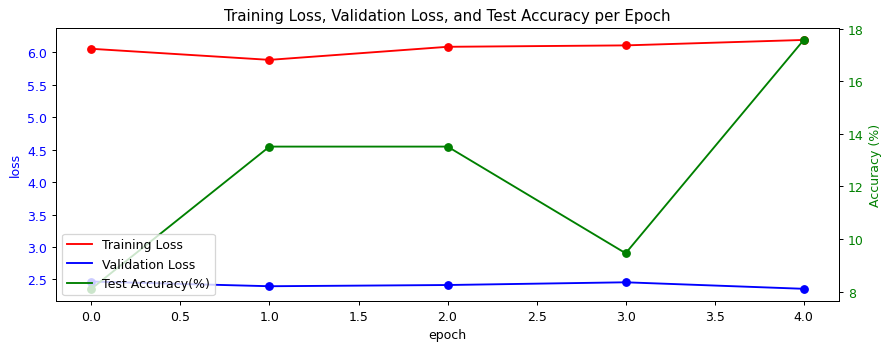

In [ ]:
import matplotlib.pyplot as plt

def ploting(ax, arr, color,lname, ylabel='loss', xlabel='epoch'):
    ax.plot(arr, color=color, label=lname)
    ax.scatter(range(len(arr)), arr, color=color)
    ax.set_ylabel(ylabel, color=color)
    ax.tick_params(axis='y', labelcolor=color)
    ax.set_xlabel(xlabel)


# Create a figure and the first axes
fig, ax1 = plt.subplots(figsize=(10, 4), dpi=90)
# Create a second axes that shares the same x-axis as the first
ax2 = ax1.twinx()

# Plotting loss and valid loss on ax1 (left y-axis)
ploting(ax1, iter_loss, color='red', lname='Training Loss')
ploting(ax1, valid_loss, color='blue', lname='Validation Loss')
# Plotting accuracy on ax2 (right y-axis)
ploting(ax2, iter_accy, color='green', lname='Test Accuracy(%)',ylabel='Accuracy (%)')

# Add a legend: Combine handles and labels from both axes
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
# Create a single legend for all lines
plt.legend(handles1 + handles2, labels1 + labels2, loc='lower left')

plt.title('Training Loss, Validation Loss, and Test Accuracy per Epoch')
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

## Validate the model

 --Validation loss:- 2.3557719230651855 --Testing....got-(13/74)-correctly-->>accuracy=(17.57%)


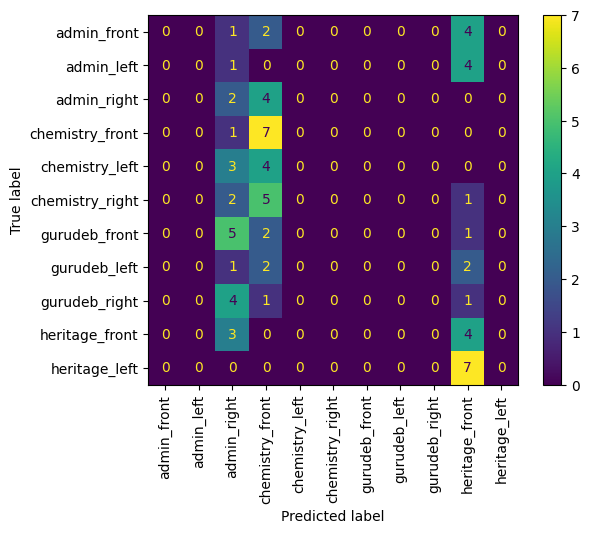

In [ ]:
# call evaluation function
accuracy,_ = eval_model_on_test(
    CNN_MODEL, test_loader, disp_confusion_matrix=True,
)

## Save trained model

In [ ]:
# print(CNN_MODEL.state_dict())
# torch.save(CNN_MODEL.state_dict(), DATA_PATH +'/resnet18_image_classifier.pth')

#save entire model
model_name = CNN_MODEL.__class__.__name__ + '18'
print(model_name)

torch.save(CNN_MODEL, DATA_PATH+'/'+model_name+'_with_'+ str(int(accuracy))+'_accy.pth')

os.listdir(DATA_PATH)

ResNet18


['make_train-test-split_from_all_img_data.ipynb',
 'ResNet18_with_56_accy.pth',
 'expr1_resnet18.ipynb',
 'validate_images',
 'training_images',
 'ALL_IMG_DATA',
 'ResNet18_with_17_accy.pth']

# Individual testing

## Predefined parameters

In [ ]:
# MODEL = DATA_PATH+"/resnet18_image_classifier_full.pth"
MODEL = CNN_MODEL
TRANSFORM = test_transform
# Update the CATEGORIES variable to be a list of keys
CATEGORIES = list(test_dataset.class_to_idx.keys())
print(CATEGORIES)


['admin_front', 'admin_left', 'admin_right', 'chemistry_front', 'chemistry_left', 'chemistry_right', 'gurudeb_front', 'gurudeb_left', 'gurudeb_right', 'heritage_front', 'heritage_left']


## Function for individual image classification

In [ ]:
from PIL import Image

def classify_this_image(img_path, model=MODEL,img_transform=TRANSFORM,classes=CATEGORIES):
    model.eval() # set model to evaluation/testing mode
    input_img = Image.open(DATA_PATH + img_path)

    plt.figure(figsize=(10, 10),dpi=30)
    plt.imshow(input_img) # display the loaded image
    plt.axis('off')
    plt.show()

    img_tensor = img_transform(input_img).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        output = model(img_tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1)
        print(probabilities)
        _, predicted_class_index = torch.max(probabilities, 1)
        predicted_class = classes[predicted_class_index.item()]
        print(f"Predicted class: {predicted_class}")

## Input image and Classify

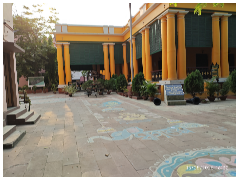

AttributeError: 'tuple' object has no attribute 'softmax'

In [ ]:
# Call the classification function
classify_this_image("/../Testing_data_mix/Heritage_test/fview_0001.jpg")
classify_this_image("/../Testing_data_mix/Admin_test/campus-admin-building.jpg")
classify_this_image("/../Testing_data_mix/Gurudeb_test/images (2).jpeg")
classify_this_image("/../Testing_data_mix/Gurudeb_test/images (3).jpeg")
classify_this_image("/../Testing_data_mix/Gurudeb_test/images (4).jpeg")
classify_this_image("/../Testing_data_mix/Heritage_test/Copy of diagonal_0002.jpg")
classify_this_image("/../Testing_data_mix/Gurudeb_test/images (5).jpeg")
classify_this_image("/../Testing_data_mix/Chemistry_test/images (8).jpeg")
classify_this_image("/../Testing_data_mix/Unknown_test/flatiron.jpeg")
classify_this_image("/../Testing_data_mix/Unknown_test/victoria.jpeg")

In [ ]:
# GradCAM